In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
#!pip -q install cdxbasics "tensorflow>=2.11" "tensorflow_probability==0.19"
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
my_path = None
if i!=-1:
    my_path = p[:i]
    import sys
    sys.path.append(my_path)
    print("SageMaker: added python path %s" % my_path)
else:
    print(sys.path)

SageMaker: added python path /Users/lisafaloughi/Desktop/DeepHedging


Deep Hedging AI says hello ... Tensorflow version 2.13.0 running on 1 CPUs and 0 GPUs


## Deep Hedging in a Black \& Scholes World

Initializing training at 2025-04-26 10:34:08: gym with 943 trainable weights compiled. Took 1s
Agent is using 941 weights: 941 for the main agent per step.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/cb437a703c43013ac0ddb4043a011d9e9da7b52feec8dcda.pck'
Cache successfully loaded. Current epoch: 800
Nothing to do: cached model loaded from /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/cb437a703c43013ac0ddb4043a011d9e9da7b52feec8dcda.pck was trained for 800 epochs; you have asked to train for 800 epochs. If you want to force training: raise number of epoc

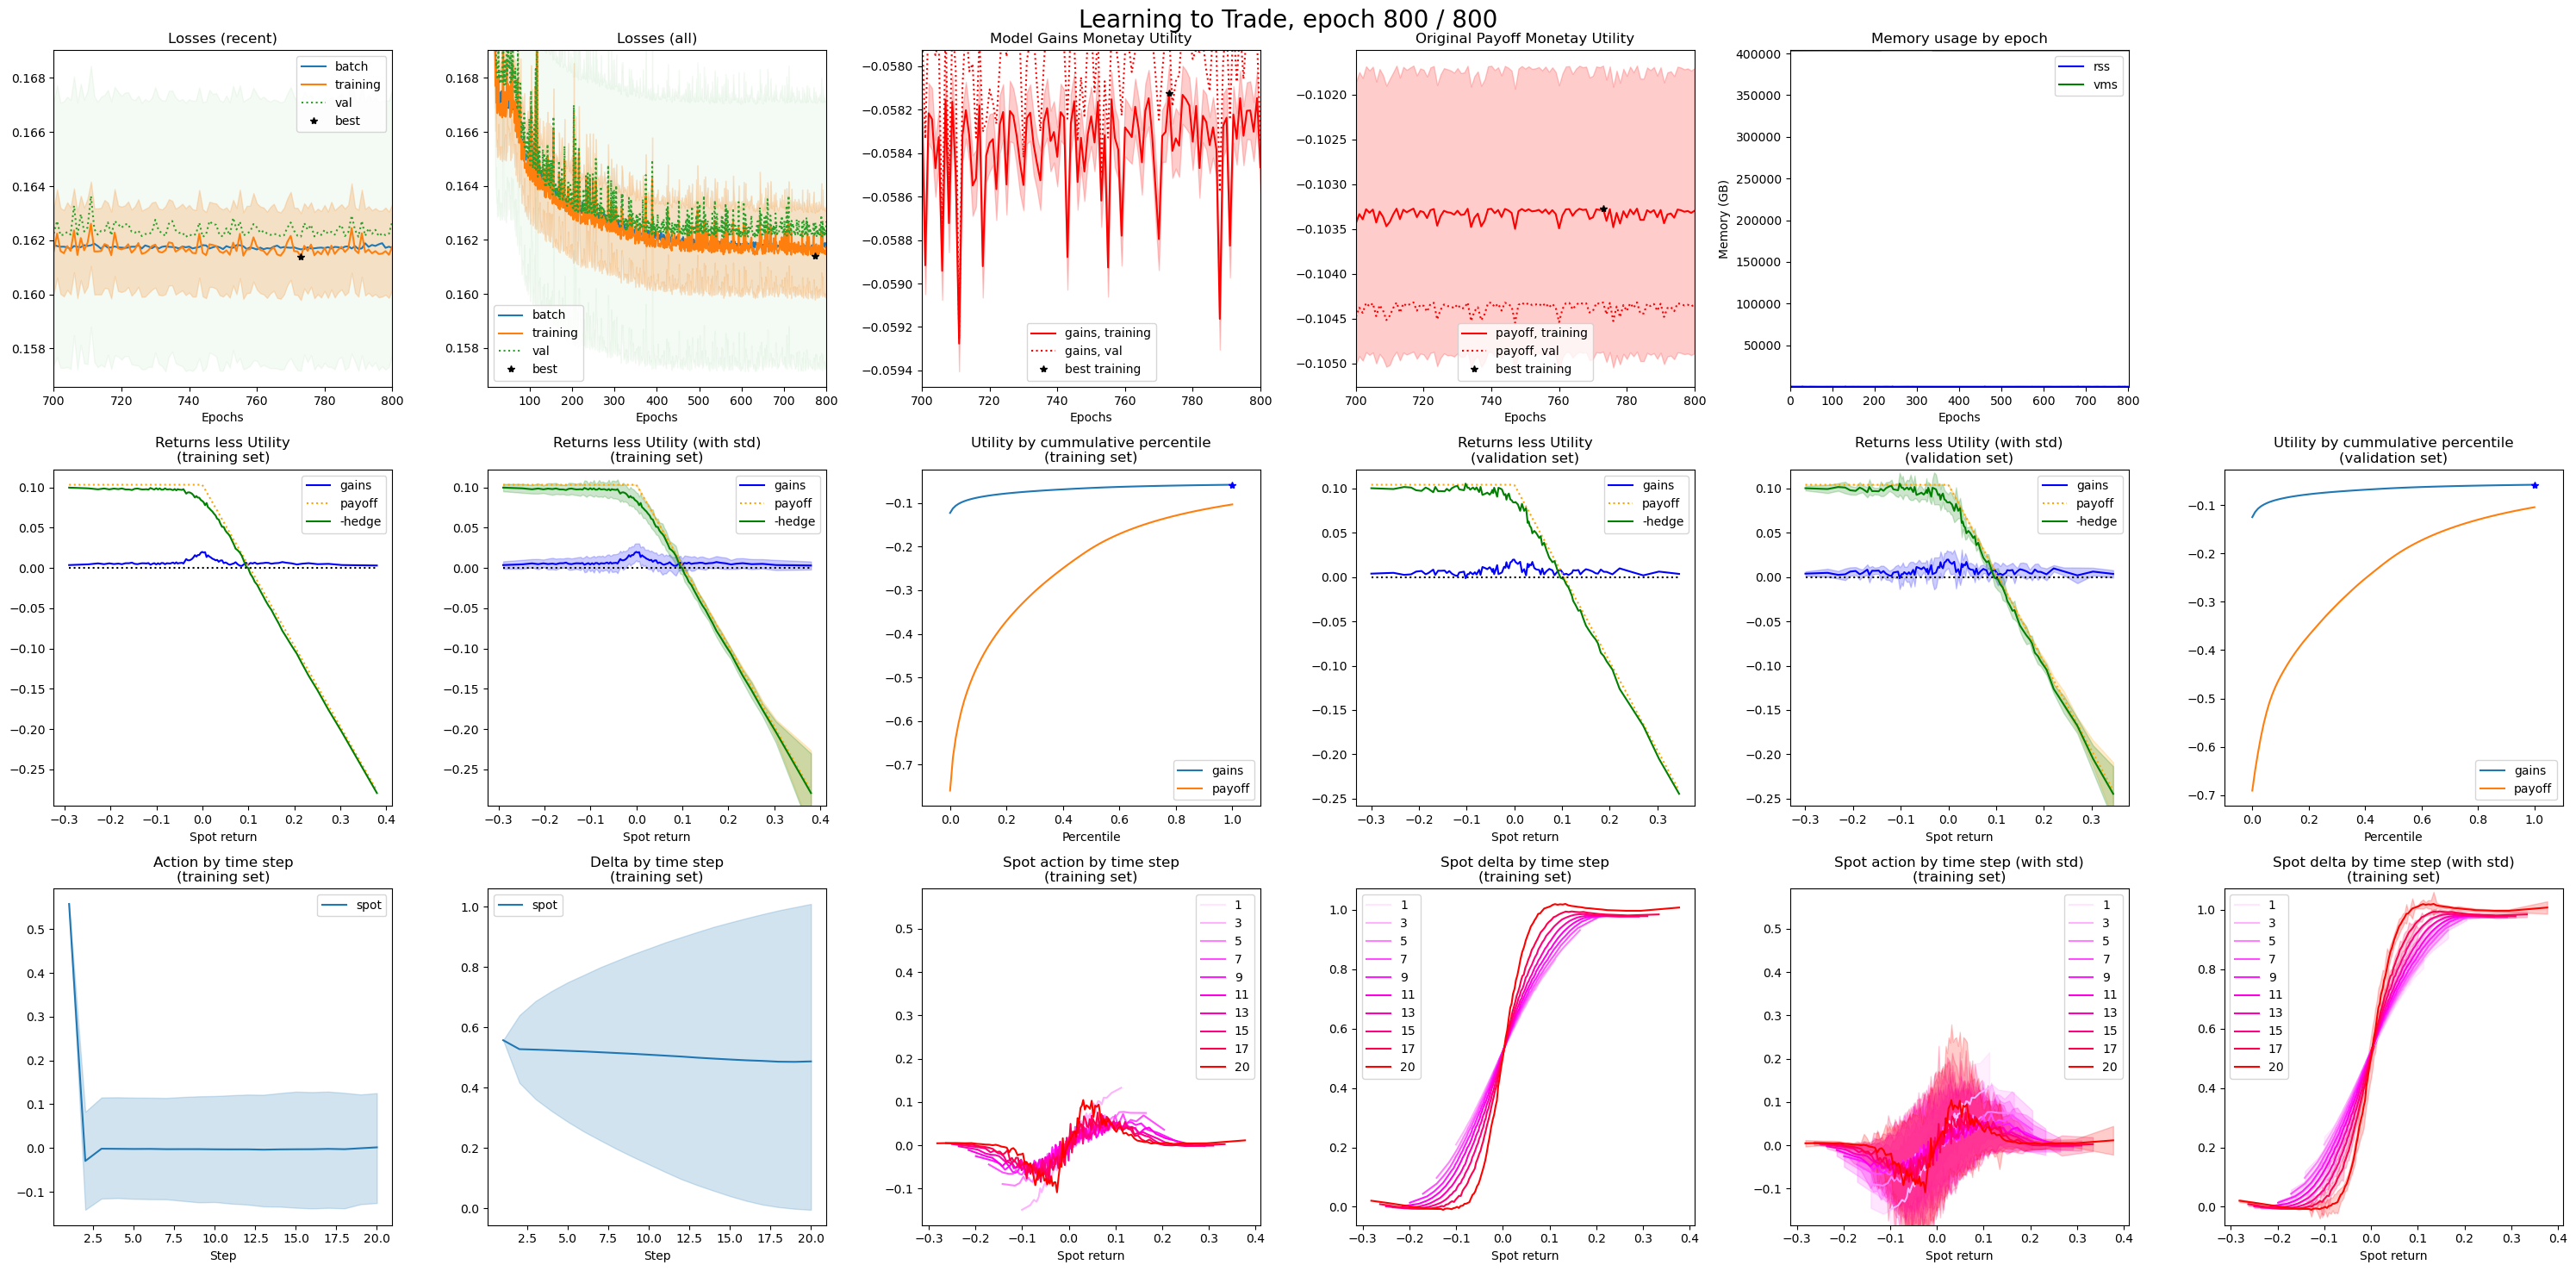

Training 800/800 epochs; 943 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.471029 (0.00718631), training 0.161761 (0.00157918), best 0.161395 (0.00718631), batch 0.161717, val 0.162687 (0.00488415); best epoch 773, last cached 800 | memory used: rss 118.953M, vms 403857M | time elapsed 48:04; time per epoch 3s; estimated time remaining 0s | current time: 2025-04-26 10:34:10                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 773
 State of training until epoch 800 cached into /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/cb437a703c43013ac0ddb4043a011d9e9da7b52feec8dcda.pck
 Time: 2025-04-26 10:34:12
Training terminated. Total time taken 3s
Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
Config usage report
config.gym.agent.init_delta['active'] = False # Whether or not to train in addi

In [2]:
print("Deep Hedging AI says hello ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.optimizer.name = "adam"
#config.trainer.train.optimizer.learning_rate = 0.001
#config.trainer.train.optimizer.clipvalue = 1.
#config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 800
config.trainer.caching.mode = "on"
config.trainer.visual.epoch_refresh = 5
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

# Disable initial delta
config.gym.agent.init_delta.active = False

display(Markdown("## Deep Hedging in a Black \& Scholes World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//10)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()


In [3]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pickle

# Step 1: Run the model
result = gym(world.tf_data)

# Step 2: Extract components
price     = world.data.features.per_step['price']       # shape: (10000, 20)
time_left = world.data.features.per_step['time_left']   # shape: (10000, 20)
actions = result['actions'].numpy()[:, :, 0]  # shape: (10000, 20)
delta = np.cumsum(actions, axis=1) - actions  # start at 0, like in actual inference

In [4]:
print("time_left shape:", delta.shape)
print("time_left min:", np.min(delta))
print("time_left max:", np.max(delta))

time_left shape: (10000, 20)
time_left min: -0.46722698
time_left max: 1.343152


In [5]:
# Step 3: Flatten and combine in correct order
X = np.stack([price, delta, time_left], axis=2)  # shape: (10000, 20, 3)

# Ensure ordering matches agent.features (sorted): delta, price, time_left
feature_names = ['price', 'delta', 'time_left']
sorted_names = sorted(feature_names)  # --> ['delta', 'price', 'time_left']

# Create index mapping
name_to_array = {
    'price': price,
    'delta': delta,
    'time_left': time_left
}
X_sorted = np.stack([name_to_array[k] for k in sorted_names], axis=2).reshape(-1, 3)

In [6]:
from sklearn.preprocessing import StandardScaler

# --- Step 2: Standardize features (zero mean, unit variance) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sorted)  # shape: (200000, 3)

In [10]:
import numpy as np
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

n_prototypes_list = [100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]

for n_prototypes in n_prototypes_list:
    print(f"Creating {n_prototypes} prototypes with medoid selection...")

    # Step 1: Cluster
    kmeans = KMeans(n_clusters=n_prototypes, random_state=0, n_init="auto")
    cluster_labels = kmeans.fit_predict(X_scaled)  # X_scaled = your extracted+standardized features

    # Step 2: Instead of cluster centers, find the closest real point (medoid)
    real_prototypes = []
    for cluster_idx in range(n_prototypes):
        # Find all points belonging to the cluster
        cluster_points = X_scaled[cluster_labels == cluster_idx]
        
        if len(cluster_points) == 0:
            print(f"⚠️ Cluster {cluster_idx} is empty!")
            continue
        
        # Find closest real point to the cluster center
        center = kmeans.cluster_centers_[cluster_idx].reshape(1, -1)
        closest_idx, _ = pairwise_distances_argmin_min(center, cluster_points)
        
        real_proto = cluster_points[closest_idx[0]]  # real sample
        real_prototypes.append(real_proto)

    real_prototypes = np.stack(real_prototypes, axis=0)

    # Step 3: Save
    filename = f"prototypes_{n_prototypes}.pkl"
    with open(filename, "wb") as f:
        pickle.dump({
            "prototypes": real_prototypes,   # real points, not means!
            "scaler": scaler
        }, f)

    print(f"✅ Saved {filename}")

Creating 100 prototypes with medoid selection...
✅ Saved prototypes_100.pkl
Creating 250 prototypes with medoid selection...
✅ Saved prototypes_250.pkl
Creating 500 prototypes with medoid selection...
✅ Saved prototypes_500.pkl
Creating 750 prototypes with medoid selection...
✅ Saved prototypes_750.pkl
Creating 1000 prototypes with medoid selection...
✅ Saved prototypes_1000.pkl
Creating 1250 prototypes with medoid selection...
✅ Saved prototypes_1250.pkl
Creating 1500 prototypes with medoid selection...
✅ Saved prototypes_1500.pkl
Creating 1750 prototypes with medoid selection...
✅ Saved prototypes_1750.pkl
Creating 2000 prototypes with medoid selection...
✅ Saved prototypes_2000.pkl


In [ ]:
# from sklearn.cluster import KMeans
# import pickle

# n_prototypes_list = [100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]

# # --- Step 3: Run KMeans clustering ---


# for n_prototypes in n_prototypes_list:
#     print(f"Creating {n_prototypes} prototypes...")

#     # Step 1: Cluster
#     kmeans = KMeans(n_clusters=n_prototypes, random_state=0, n_init="auto")
#     kmeans.fit(X_scaled)  # X_scaled = your extracted+standardized features (already computed)

#     # Step 2: Save
#     filename = f"prototypes_{n_prototypes}.pkl"
#     with open(filename, "wb") as f:
#         pickle.dump({
#             "prototypes": kmeans.cluster_centers_,
#             "scaler": scaler  # the same StandardScaler used for X_scaled
#         }, f)
    
#     print(f"✅ Saved {filename}")

Creating 100 prototypes...
✅ Saved prototypes_100.pkl
Creating 250 prototypes...
✅ Saved prototypes_250.pkl
Creating 500 prototypes...
✅ Saved prototypes_500.pkl
Creating 750 prototypes...
✅ Saved prototypes_750.pkl
Creating 1000 prototypes...
✅ Saved prototypes_1000.pkl
Creating 1250 prototypes...
✅ Saved prototypes_1250.pkl
Creating 1500 prototypes...
✅ Saved prototypes_1500.pkl
Creating 1750 prototypes...
✅ Saved prototypes_1750.pkl
Creating 2000 prototypes...
✅ Saved prototypes_2000.pkl


In [54]:
import numpy as np

prototypes = kmeans.cluster_centers_

# Set print options for cleaner display
np.set_printoptions(precision=3, suppress=True)

# Compute min and max for each column (feature)
X_min = X_scaled.min(axis=0)
X_max = X_scaled.max(axis=0)

proto_min = prototypes.min(axis=0)
proto_max = prototypes.max(axis=0)

# Print results
print("Feature order: [delta, price, time_left]\n")

print("X_sorted:")
print("  Min:", X_min)
print("  Max:", X_max)

print("\nPrototypes:")
print("  Min:", proto_min)
print("  Max:", proto_max)

Feature order: [delta, price, time_left]

X_sorted:
  Min: [-3.191 -4.486 -1.648]
  Max: [2.88  6.467 1.648]

Prototypes:
  Min: [-2.619 -4.167 -1.648]
  Max: [2.126 6.156 1.647]


In [55]:
prototypes = kmeans.cluster_centers_

# --- Step 4: Save cluster centers and the fitted scaler ---
with open("prototypes.pkl", "wb") as f:
    pickle.dump({
        "prototypes": kmeans.cluster_centers_,  # standardized space!
        "scaler": scaler                        # full StandardScaler object
    }, f)

print("✅ Prototypes and scaler saved to prototypes.pkl")

✅ Prototypes and scaler saved to prototypes.pkl


In [14]:
import pickle

# Load prototypes
with open("prototypes_1500.pkl", "rb") as f:
    data = pickle.load(f)

prototypes = data["prototypes"]    # shape: (250, 3) if you had 3 features
scaler = data["scaler"]             # the StandardScaler you used

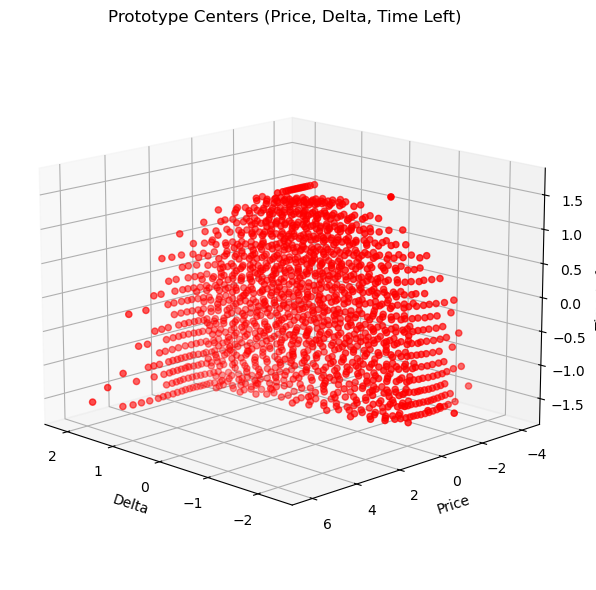

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Extract individual axes
x = prototypes[:, 0]  # Delta
y = prototypes[:, 1]  # Price
z = prototypes[:, 2]  # Time Left

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Plot
ax.scatter(x, y, z, c='red', s=20)

# Set labels
ax.set_xlabel("Delta")
ax.set_ylabel("Price")
ax.set_zlabel("Time Left")

# Optional: Adjust the viewing angle
ax.view_init(elev=15, azim=135)

ax.set_title("Prototype Centers (Price, Delta, Time Left)")
plt.tight_layout()
plt.show()

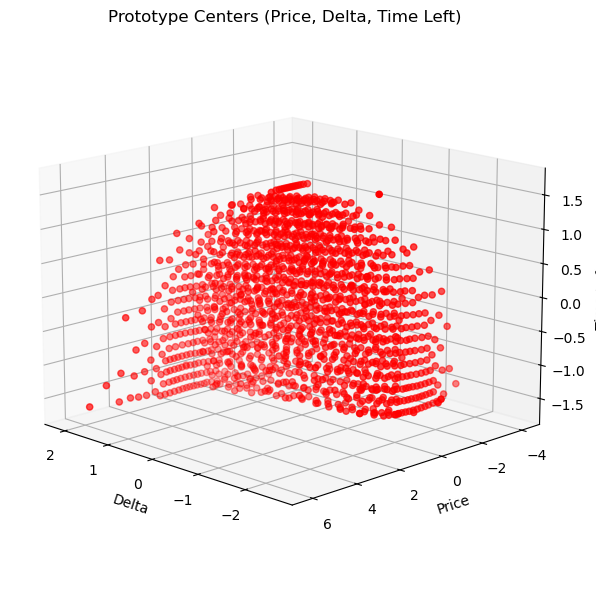

In [56]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Extract individual axes
x = prototypes[:, 0]  # Delta
y = prototypes[:, 1]  # Price
z = prototypes[:, 2]  # Time Left

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Plot
ax.scatter(x, y, z, c='red', s=20)

# Set labels
ax.set_xlabel("Delta")
ax.set_ylabel("Price")
ax.set_zlabel("Time Left")

# Optional: Adjust the viewing angle
ax.view_init(elev=15, azim=135)

ax.set_title("Prototype Centers (Price, Delta, Time Left)")
plt.tight_layout()
plt.show()

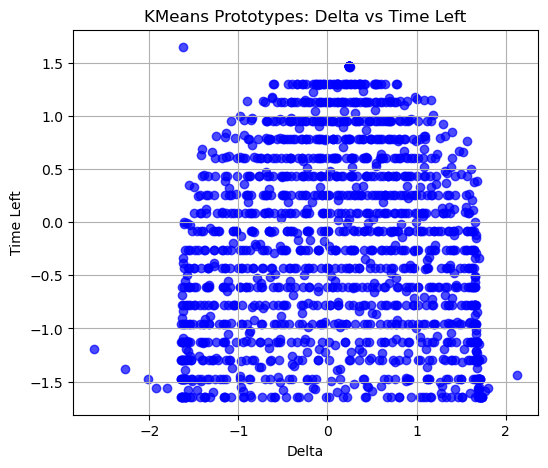

In [57]:
import matplotlib.pyplot as plt

# Select delta and time_left dimensions from your prototypes
# Assuming columns: [price, delta, time_left]
delta = prototypes[:, 0]
time_left = prototypes[:, 2]

# Plotting
plt.figure(figsize=(6, 5))
plt.scatter(delta, time_left, c='blue', alpha=0.7)
plt.title("KMeans Prototypes: Delta vs Time Left")
plt.xlabel("Delta")
plt.ylabel("Time Left")
plt.grid(True)
plt.show()

## Stochastic Prototypes - No Initial Delta

Deep Hedging AI says hello  ... 

## Deep Hedging in a simple Stochastic Volatility World

Initializing training at 2025-04-26 11:18:33: gym with 1004 trainable weights compiled. Took 1s
Agent is using 1002 weights: 1002 for the main agent per step.
 Features available per time step:     action, call_delta, call_price, call_vega, cost, cost_v, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
Monetary utility cvar@1 is using 1 weight
 Features available: call_delta, call_price, call_vega, cost, cost_v, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/254707f31dc64df7e1ec8dc97ccac7b6c4a94d484b844f0b.pck'
Cache successfully loaded. Current epoch: 800
Nothing to do: cached model loaded from /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/254707f31dc64df7e1ec8dc97ccac7b6c4a94d484b844f0b.pck was trained for 800 epochs; yo

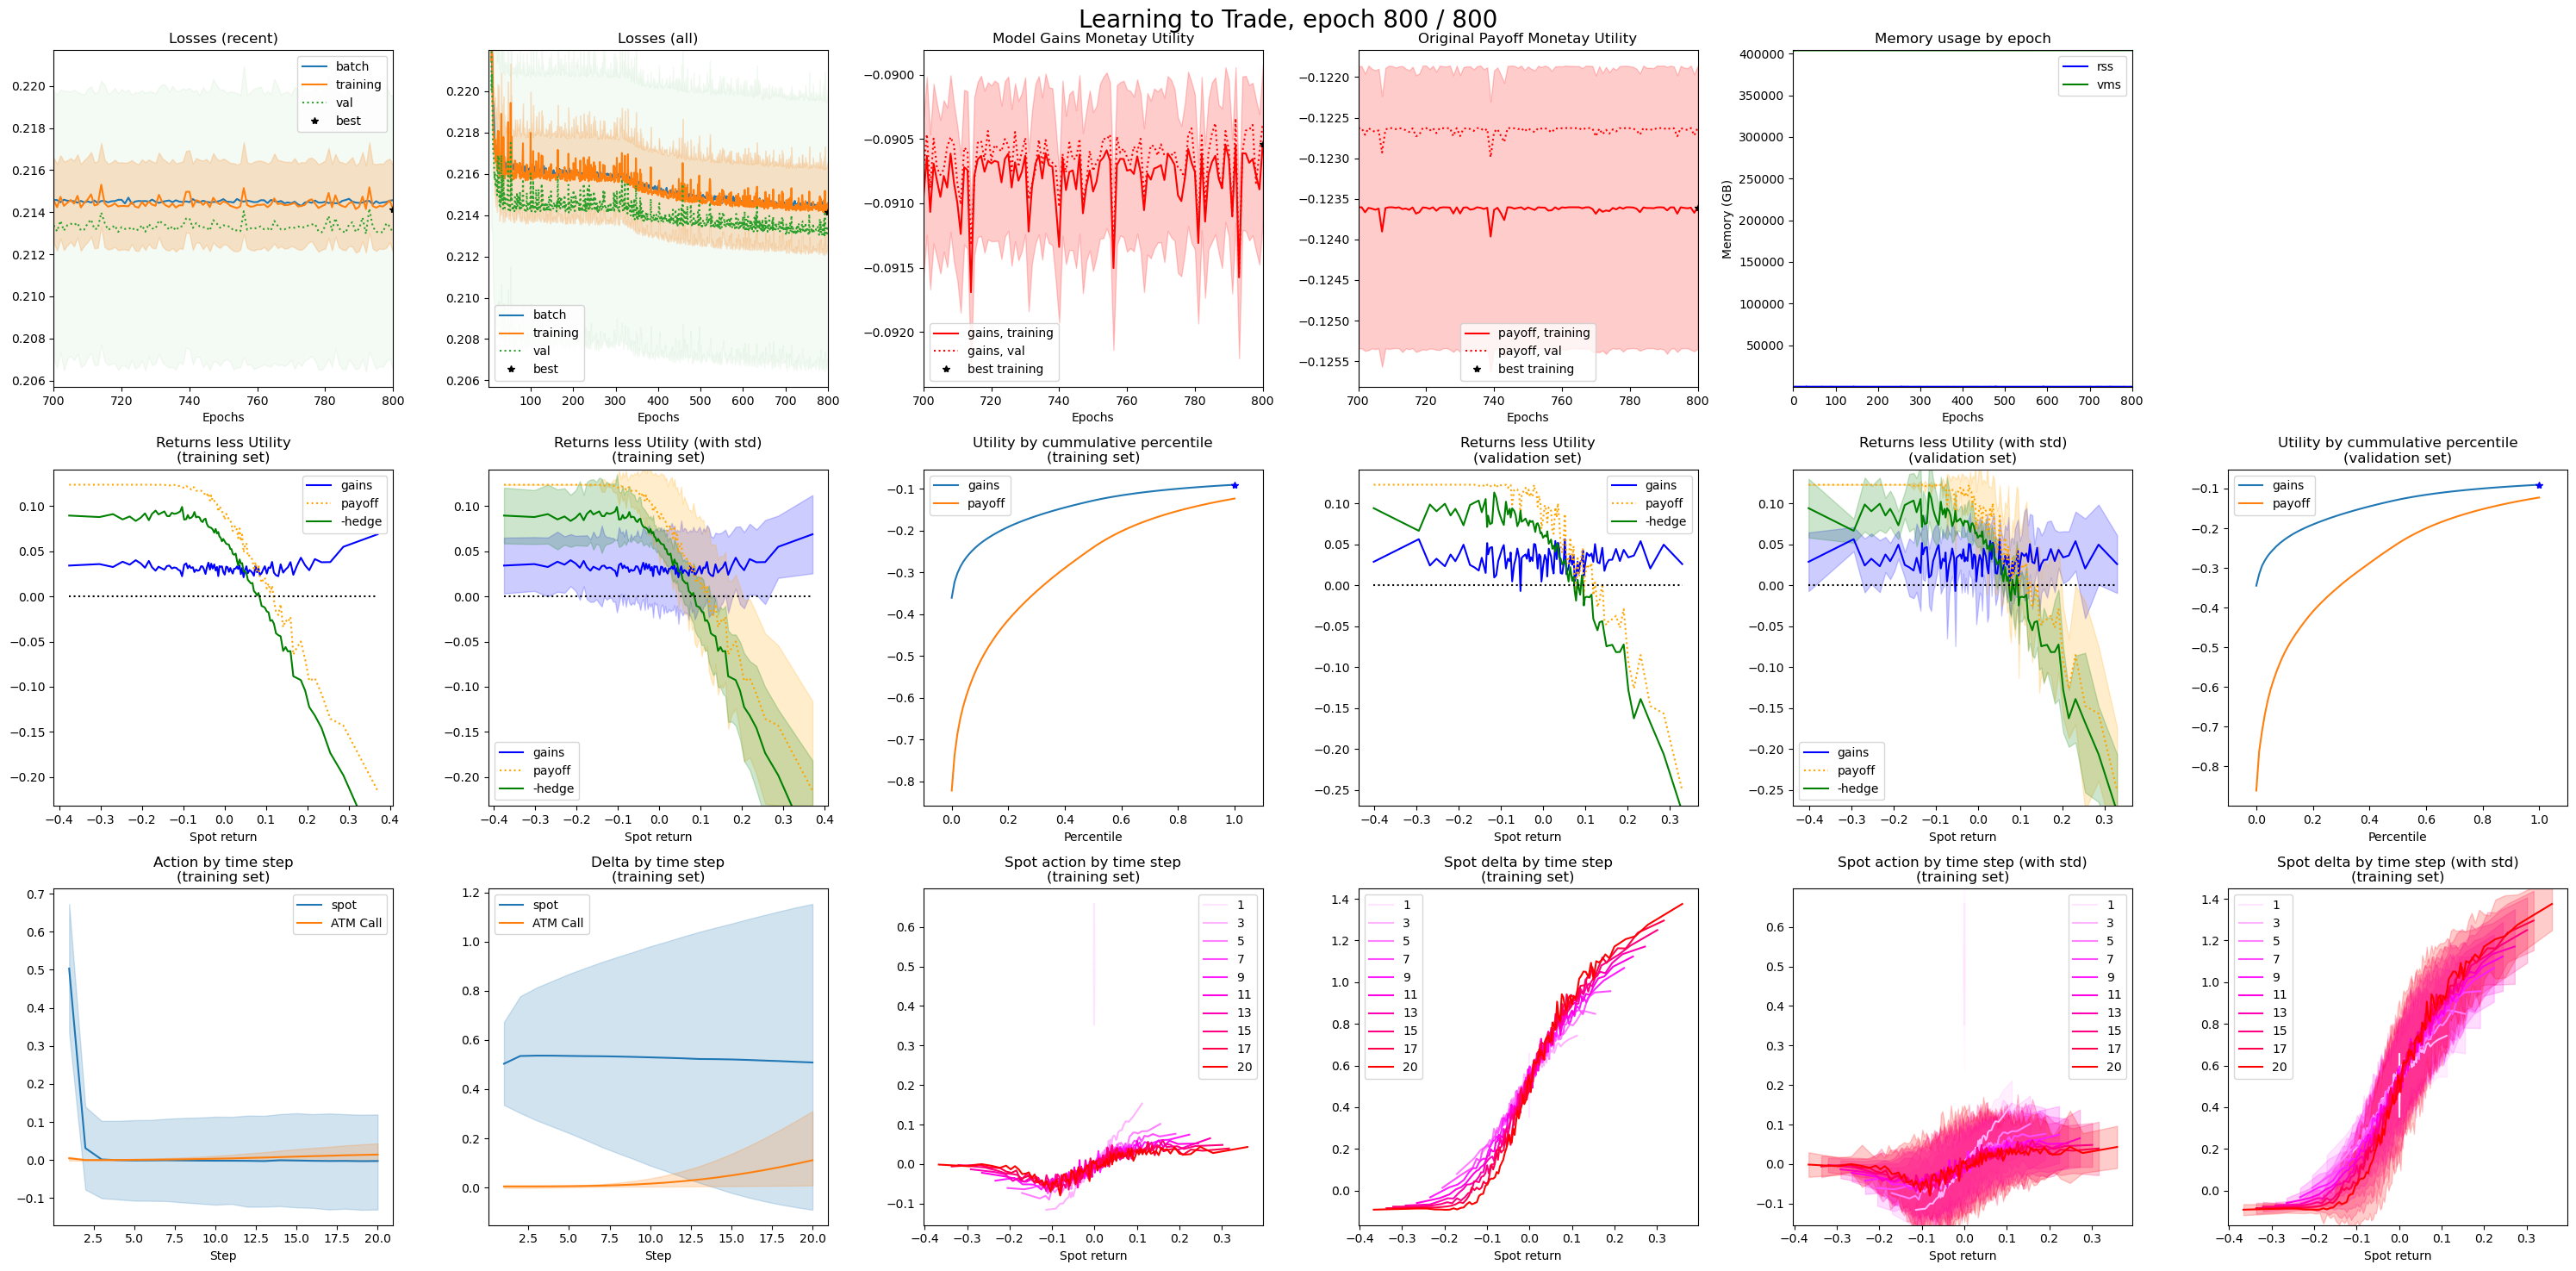

Training 800/800 epochs; 1004 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.644496 (0.00910156), training 0.214142 (0.00206014), best 0.214142 (0.00910156), batch 0.214575, val 0.213005 (0.00651256); best epoch 800, last cached 800 | memory used: rss 148.438M, vms 404023M | time elapsed 58:42; time per epoch 4s; estimated time remaining 0s | current time: 2025-04-26 11:18:36                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 800
 State of training until epoch 800 cached into /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/254707f31dc64df7e1ec8dc97ccac7b6c4a94d484b844f0b.pck
 Time: 2025-04-26 11:18:37
Training terminated. Total time taken 4s
Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
Config usage report
config.gym.agent.init_delta['active'] = False # Whether or not to train in add

In [16]:
print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import tensorflow as tf

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = False
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.optimizer.name = "adam"
config.trainer.train.optimizer.learning_rate = 0.001
config.trainer.train.optimizer.clipvalue = 1.
config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 800
config.trainer.caching.mode = "on"
config.trainer.train.run_eagerly = None
config.trainer.visual.epoch_refresh = 5
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

# Disable initial delta
config.gym.agent.init_delta.active = False

display(Markdown("## Deep Hedging in a simple Stochastic Volatility World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//10)

# create training environment
tf.debugging.enable_check_numerics()
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

In [17]:
import numpy as np
import pickle
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Step 1: Run the model
result = gym(world.tf_data)

# Step 2: Extract per-step components
price      = world.data.features.per_step['price']       # shape: (10000, 20, 2)
time_left  = world.data.features.per_step['time_left']   # shape: (10000, 20)
actions    = result["actions"].numpy()                   # shape: (10000, 20, 2)
delta = np.cumsum(actions, axis=1) - actions             # shape: (10000, 20, 2)

In [23]:
print("time_left shape:", actions.shape)
print("time_left min:", np.min(delta, axis=(0, 1)))
print("time_left max:", np.max(delta))

time_left shape: (10000, 20, 2)
time_left min: [-0.21666384 -0.02369404]
time_left max: 1.7007027


In [24]:
# Flatten and stack feature vectors into shape (10000 * 20, 5)
# Features: [price_1, delta_1, price_2, delta_2, time_left]
price_1 = price[:, :, 0].reshape(-1)
delta_1 = delta[:, :, 0].reshape(-1)
price_2 = price[:, :, 1].reshape(-1)
delta_2 = delta[:, :, 1].reshape(-1)
time    = time_left.reshape(-1)

# Final feature matrix: [samples * timesteps, 5]
X_all = np.stack([delta_1, delta_2, price_1, price_2, time], axis=1)
print("✅ X_all shape:", X_all.shape)  # Expect (200000, 5)

✅ X_all shape: (200000, 5)


In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

print("Feature-wise min/max after scaling:")
print("Min:", X_scaled.min(axis=0))
print("Max:", X_scaled.max(axis=0))

Feature-wise min/max after scaling:
Min: [-1.9734852 -0.7433809 -5.888356  -2.7831306 -1.647509 ]
Max: [ 3.31123   16.170652   5.249192   8.381535   1.6475089]


In [ ]:
# from sklearn.cluster import KMeans

# n_prototypes = 3000
# kmeans = KMeans(n_clusters=n_prototypes, random_state=0, n_init='auto')
# kmeans.fit(X_scaled)

# prototypes = kmeans.cluster_centers_

In [27]:
import numpy as np
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

n_prototypes_list = [100, 300, 750, 1500, 2250, 3000, 3750]

for n_prototypes in n_prototypes_list:
    print(f"Creating {n_prototypes} prototypes with medoid selection...")

    # Step 1: Cluster
    kmeans = KMeans(n_clusters=n_prototypes, random_state=0, n_init="auto")
    cluster_labels = kmeans.fit_predict(X_scaled)  # X_scaled = your extracted+standardized features

    # Step 2: Instead of cluster centers, find the closest real point (medoid)
    real_prototypes = []
    for cluster_idx in range(n_prototypes):
        # Find all points belonging to the cluster
        cluster_points = X_scaled[cluster_labels == cluster_idx]
        
        if len(cluster_points) == 0:
            print(f"⚠️ Cluster {cluster_idx} is empty!")
            continue
        
        # Find closest real point to the cluster center
        center = kmeans.cluster_centers_[cluster_idx].reshape(1, -1)
        closest_idx, _ = pairwise_distances_argmin_min(center, cluster_points)
        
        real_proto = cluster_points[closest_idx[0]]  # real sample
        real_prototypes.append(real_proto)

    real_prototypes = np.stack(real_prototypes, axis=0)
    
    # check if we have duplicates
    # (this should not happen, but just in case)

    n_unique = np.unique(real_prototypes, axis=0).shape[0]
    print(f"Got {n_unique} unique prototypes out of {len(real_prototypes)}")

    # Step 3: Save
    filename = f"prototypes_stochastic_{n_prototypes}.pkl"
    with open(filename, "wb") as f:
        pickle.dump({
            "prototypes": real_prototypes,   # real points, not means!
            "scaler": scaler
        }, f)

    print(f"✅ Saved {filename}")

Creating 100 prototypes with medoid selection...
Got 100 unique prototypes out of 100
✅ Saved prototypes_stochastic_100.pkl
Creating 300 prototypes with medoid selection...
Got 300 unique prototypes out of 300
✅ Saved prototypes_stochastic_300.pkl
Creating 750 prototypes with medoid selection...
Got 750 unique prototypes out of 750
✅ Saved prototypes_stochastic_750.pkl
Creating 1500 prototypes with medoid selection...
Got 1500 unique prototypes out of 1500
✅ Saved prototypes_stochastic_1500.pkl
Creating 2250 prototypes with medoid selection...
Got 2250 unique prototypes out of 2250
✅ Saved prototypes_stochastic_2250.pkl
Creating 3000 prototypes with medoid selection...
Got 3000 unique prototypes out of 3000
✅ Saved prototypes_stochastic_3000.pkl
Creating 3750 prototypes with medoid selection...
Got 3750 unique prototypes out of 3750
✅ Saved prototypes_stochastic_3750.pkl


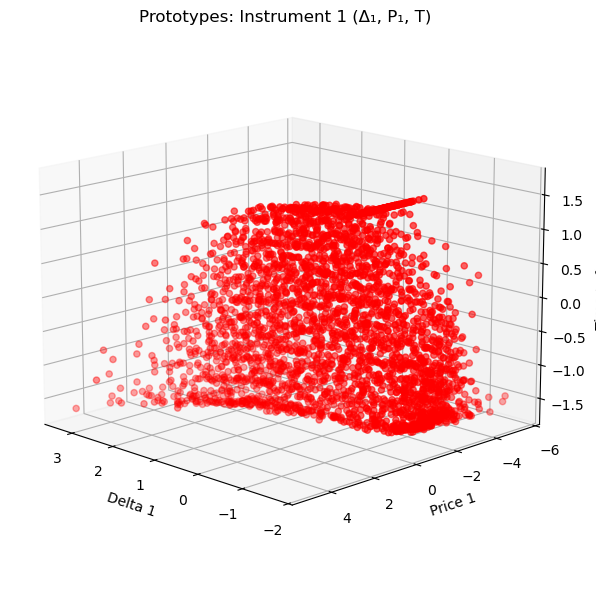

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

x = prototypes[:, 0]  # delta₁
y = prototypes[:, 2]  # price₁
z = prototypes[:, 4]  # time_left

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='red', s=20)

ax.set_xlabel("Delta 1")
ax.set_ylabel("Price 1")
ax.set_zlabel("Time Left")
ax.view_init(elev=15, azim=135)
ax.set_title("Prototypes: Instrument 1 (Δ₁, P₁, T)")
plt.tight_layout()
plt.show()

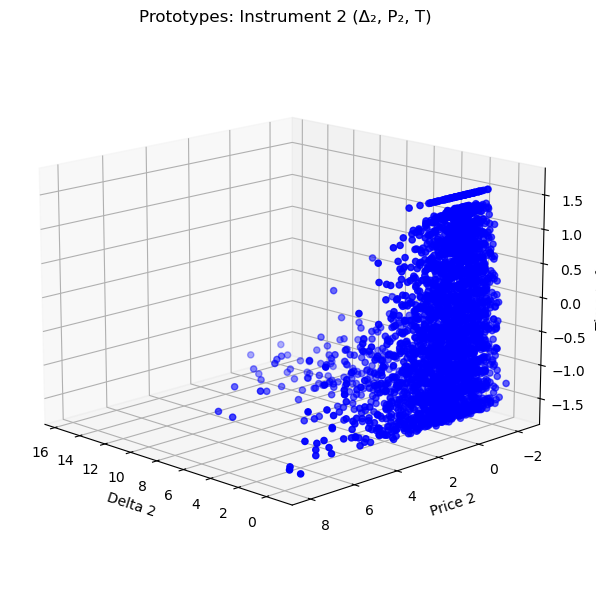

In [68]:
x = prototypes[:, 1]  # delta₂
y = prototypes[:, 3]  # price₂
z = prototypes[:, 4]  # time_left

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='blue', s=20)

ax.set_xlabel("Delta 2")
ax.set_ylabel("Price 2")
ax.set_zlabel("Time Left")
ax.view_init(elev=15, azim=135)
ax.set_title("Prototypes: Instrument 2 (Δ₂, P₂, T)")
plt.tight_layout()
plt.show()

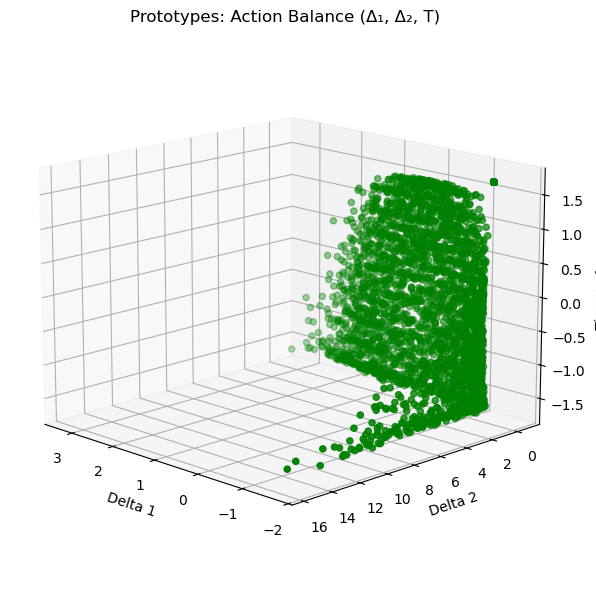

In [69]:
x = prototypes[:, 0]  # delta₁
y = prototypes[:, 1]  # delta₂
z = prototypes[:, 4]  # time_left

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='green', s=20)

ax.set_xlabel("Delta 1")
ax.set_ylabel("Delta 2")
ax.set_zlabel("Time Left")
ax.view_init(elev=15, azim=135)
ax.set_title("Prototypes: Action Balance (Δ₁, Δ₂, T)")
plt.tight_layout()
plt.show()

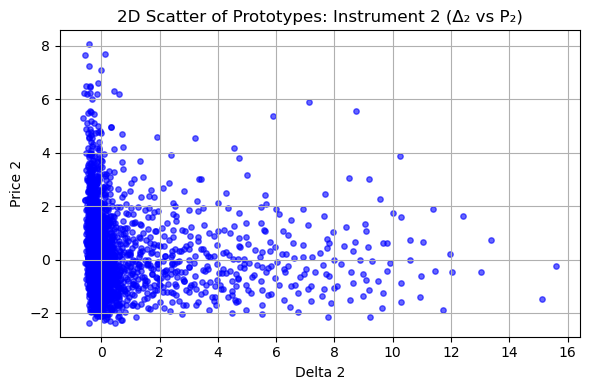

In [70]:
import matplotlib.pyplot as plt

# Extract 2D coordinates
x = prototypes[:, 1]  # delta₂
y = prototypes[:, 3]  # price₂

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(x, y, c='blue', s=15, alpha=0.6)

# Labels and title
plt.xlabel("Delta 2")
plt.ylabel("Price 2")
plt.title("2D Scatter of Prototypes: Instrument 2 (Δ₂ vs P₂)")
plt.grid(True)
plt.tight_layout()
plt.show()